# Battle of the Neighborhoods
## Coursera Capstone

## Introduction / Business Problem

A client wishes to open up a business of his/her choice in the city of Toronto. The client however does not know what optimal location to place their business in. Our task is to select/recommend a suitable location for them.

## Data

For this assignment, we will look at a location using data such as postal code and clusters from our previous modules. We will combine this data with input from the client (i.e. max radius from nearest business of the same type, type of business) and Foursquare API calls to see similar business in the same viscinity. Combining this data we will use K-Nearest Neighbor from the sci-kit library to show the clusters of businesses and show a representation of this on a Folium map. We will then recommend (2) possible locations for the client:

1. A location that has the most cluster of similar business types since consumers may look to goto that cluster from previous experience to find that particular business.
2. A location where there are none of that type of business in that cluster which will introduce no competition for our client since it will only be the client serving their particular kind of customers.

For this example we will use `coffee shop` as the business.

## Methodology

We will generate a map of NYC's 5 boroughs for this Capstone. I originally was going to use Toronto as the basis for this analysis but upon experimenting with Foursquare API, I am unable to return search queries for that area. Potentiall this can be due to COVID-19 having businesses closed for the time being and resulting in no open businesses of the query search. I have had more success using New York City to obtain query searches, therefore I will proceed with NYC. 

*For Module 3 reference please see*: [Week_3 Notebook](https://github.com/jye0325/Coursera_Capstone/blob/master/Week_3.ipynb)

### List of NYC Neighborhoods are downloaded

In [1]:
!wget -O index.html https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

--2020-04-21 19:48:16--  https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm
Resolving www.health.ny.gov (www.health.ny.gov)... 150.142.196.3
Connecting to www.health.ny.gov (www.health.ny.gov)|150.142.196.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'index.html'

     0K .......... ..........                                   979K=0.02s

2020-04-21 19:48:16 (979 KB/s) - 'index.html' saved [20707]



### Neighborhoods are then converted to a DataFrame using BeautifulSoup and Pandas

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

fp = open('index.html', encoding="utf-8")
soup = BeautifulSoup(fp, 'html5lib')
table = soup.table.prettify()

df = pd.read_html(table, na_values=[])
df = df[0]

### Modify the table to have Zip Codes listing Neighborhoods

In [3]:
# Rearrange columns
df = df[['ZIP Codes', 'Borough', 'Neighborhood']]
df_copy = pd.DataFrame()
for index, row in df.iterrows():
    splits = row[0].split(',')
    for split in splits:
        a_row = pd.Series([split.strip(), row[1], row[2]])
        a_row = pd.DataFrame([a_row])
        df_copy = pd.concat([a_row, df_copy])
df_copy.rename(columns={0:'ZIP Code', 1:'Borough', 2:'Neighborhood'}, inplace=True)
df_copy.reset_index(drop=True, inplace=True)

### Google Geocoding API used to obtain latitude and longitude of the Zip Codes.
**Note: API Key will not be disclosed in this `.ipynb` file or Github commit!**

In [4]:
"""
# Commented out to avoid accidentally making API Calls to Google API for quota purposes.
import requests
import time
import json

zip_codes = pd.DataFrame()

with open('google_cloud_credentials.json', 'r') as f:
    datastore = json.load(f)

for z in df_copy['ZIP Code']:
    url = 'https://maps.googleapis.com/maps/api/geocode/json?'
    data = {
        "address":"{}".format(z),
        "key":datastore['key']
    }
    response = requests.get(url, params=data)

    data = json.loads(response.text)

    location = data['results'][0]['geometry']['location']
    
    # Create rectangular boundary
    northeast = data['results'][0]['geometry']['viewport']['northeast']
    southwest = data['results'][0]['geometry']['viewport']['southwest']
    top_lat = northeast['lat']
    top_lng = northeast['lng']
    bot_lat = southwest['lat']
    bot_lng = southwest['lng']

    c1 = '{}, {}'.format(top_lng, top_lat)
    c2 = '{}, {}'.format(bot_lng, top_lat)
    c3 = '{}, {}'.format(bot_lng, bot_lat)
    c4 = '{}, {}'.format(top_lng, bot_lat)

    a_row = pd.Series([z, float(location['lat']), float(location['lng']), c1, c2, c3, c4])
    a_row = pd.DataFrame([a_row])
    zip_codes = pd.concat([a_row, zip_codes])
"""

'\n# Commented out to avoid accidentally making API Calls to Google API for quota purposes.\nimport requests\nimport time\nimport json\n\nzip_codes = pd.DataFrame()\n\nwith open(\'google_cloud_credentials.json\', \'r\') as f:\n    datastore = json.load(f)\n\nfor z in df_copy[\'ZIP Code\']:\n    url = \'https://maps.googleapis.com/maps/api/geocode/json?\'\n    data = {\n        "address":"{}".format(z),\n        "key":datastore[\'key\']\n    }\n    response = requests.get(url, params=data)\n\n    data = json.loads(response.text)\n\n    location = data[\'results\'][0][\'geometry\'][\'location\']\n    \n    # Create rectangular boundary\n    northeast = data[\'results\'][0][\'geometry\'][\'viewport\'][\'northeast\']\n    southwest = data[\'results\'][0][\'geometry\'][\'viewport\'][\'southwest\']\n    top_lat = northeast[\'lat\']\n    top_lng = northeast[\'lng\']\n    bot_lat = southwest[\'lat\']\n    bot_lng = southwest[\'lng\']\n\n    c1 = \'{}, {}\'.format(top_lng, top_lat)\n    c2 = \'

In [5]:
#zip_codes.rename(columns={0:'ZIP Code', 1:'Latitude', 2:'Longitude', 3:'c1', 4:'c2', 5:'c3', 6:'c4'}, inplace=True)
#zip_codes.reset_index(drop=True, inplace=True)

### Save `zip_codes` DataFrame to Avoid Extra API Calls to Google

In [6]:
## Commented out to avoid accidentally overriding existing .csv file with a blank DataFrame if Kernel is restarted.
#zip_codes.to_csv('zip_codes.csv')

### Load `zip_codes` into a DataFrame (when restarting kernel or notebook) and modify data types to be compatible

In [7]:
zip_codes = pd.read_csv('zip_codes.csv', index_col=0)
zip_codes['ZIP Code'] = zip_codes['ZIP Code'].astype(int)
zip_codes['Latitude'] = zip_codes['Latitude'].astype(float)
zip_codes['Longitude'] = zip_codes['Longitude'].astype(float)
zip_codes['c1'] = zip_codes['c1'].astype(str)
zip_codes['c2'] = zip_codes['c2'].astype(str)
zip_codes['c3'] = zip_codes['c3'].astype(str)
zip_codes['c4'] = zip_codes['c4'].astype(str)

In [8]:
zip_codes

ZIP Code   Latitude  Longitude                              c1  \
0       10453  40.851587 -73.915407         -73.8999489, 40.8606009   
1       10457  40.844139 -73.897769             -73.88382, 40.85742   
2       10460  40.841618 -73.880130           -73.862837, 40.857509   
3       10458  40.862179 -73.886010         -73.8739271, 40.8793399   
4       10467  40.872399 -73.871310          -73.855691, 40.8965519   
..        ...        ...        ...                             ...   
173     10312  40.555548 -74.182712          -74.145088, 40.5784108   
174     10301  40.627439 -74.094631          -74.0693309, 40.649468   
175     10304  40.604735 -74.091694          -74.0687611, 40.638096   
176     10305  40.594406 -74.071136  -74.05141590000001, 40.6274079   
177     10314  40.595215 -74.182712           -74.109539, 40.635172   

                                 c2                              c3  \
0           -73.9284401, 40.8606009          -73.9284401, 40.844632   
1             -73.9131369, 40.85742  -73.9131369, 40.83434279999999   
2            -73.8969659, 40.857509  -73.8969659, 40.83025689999999   
3           -73.8999489, 40.8793399         -73.8999489, 40.8509489   
4    -73.88771489999999, 40.8965519   -73.88771489999999, 40.854977   
..                              ...                             ...   
173  -74.21299479999999, 40.5784108  -74.21299479999999, 40.5097569   
174          -74.1196691, 40.649468           -74.1196691, 40.60057   
175   -74.12311179999999, 40.638096  -74.12311179999999, 40.5775808   
176         -74.1019759, 40.6274079         -74.1019759, 40.5667179   
177           -74.208659, 40.635172           -74.208659, 40.566443   

                                 c4  
0            -73.8999489, 40.844632  
1      -73.88382, 40.83434279999999  
2     -73.862837, 40.83025689999999  
3           -73.8739271, 40.8509489  
4             -73.855691, 40.854977  
..                              ...  
173          -74.145088, 40.5097569  
174           -74.0693309, 40.60057  
175         -74.0687611, 40.5775808  
176  -74.05141590000001, 40.5667179  
177           -74.109539, 40.566443  

[178 rows x 7 columns]

### Modify `df_copy` data types to be compatible

In [9]:
df_copy['ZIP Code'] = df_copy['ZIP Code'].astype(int)
df_copy['Borough'] = df_copy['Borough'].astype(str)
df_copy['Neighborhood'] = df_copy['Neighborhood'].astype(str)

### Merge the two DataFrames

In [10]:
result = pd.merge(df_copy, zip_codes, how="left", on=['ZIP Code'])

result

ZIP Code        Borough              Neighborhood   Latitude  Longitude  \
0       10314  Staten Island                Mid-Island  40.595215 -74.182712   
1       10305  Staten Island  Stapleton and St. George  40.594406 -74.071136   
2       10304  Staten Island  Stapleton and St. George  40.604735 -74.091694   
3       10301  Staten Island  Stapleton and St. George  40.627439 -74.094631   
4       10312  Staten Island               South Shore  40.555548 -74.182712   
..        ...            ...                       ...        ...        ...   
173     10467          Bronx    Bronx Park and Fordham  40.872399 -73.871310   
174     10458          Bronx    Bronx Park and Fordham  40.862179 -73.886010   
175     10460          Bronx             Central Bronx  40.841618 -73.880130   
176     10457          Bronx             Central Bronx  40.844139 -73.897769   
177     10453          Bronx             Central Bronx  40.851587 -73.915407   

                                 c1                              c2  \
0             -74.109539, 40.635172           -74.208659, 40.635172   
1    -74.05141590000001, 40.6274079         -74.1019759, 40.6274079   
2            -74.0687611, 40.638096   -74.12311179999999, 40.638096   
3            -74.0693309, 40.649468          -74.1196691, 40.649468   
4            -74.145088, 40.5784108  -74.21299479999999, 40.5784108   
..                              ...                             ...   
173          -73.855691, 40.8965519  -73.88771489999999, 40.8965519   
174         -73.8739271, 40.8793399         -73.8999489, 40.8793399   
175           -73.862837, 40.857509          -73.8969659, 40.857509   
176             -73.88382, 40.85742           -73.9131369, 40.85742   
177         -73.8999489, 40.8606009         -73.9284401, 40.8606009   

                                 c3                              c4  
0             -74.208659, 40.566443           -74.109539, 40.566443  
1           -74.1019759, 40.5667179  -74.05141590000001, 40.5667179  
2    -74.12311179999999, 40.5775808         -74.0687611, 40.5775808  
3             -74.1196691, 40.60057           -74.0693309, 40.60057  
4    -74.21299479999999, 40.5097569          -74.145088, 40.5097569  
..                              ...                             ...  
173   -73.88771489999999, 40.854977           -73.855691, 40.854977  
174         -73.8999489, 40.8509489         -73.8739271, 40.8509489  
175  -73.8969659, 40.83025689999999   -73.862837, 40.83025689999999  
176  -73.9131369, 40.83434279999999    -73.88382, 40.83434279999999  
177          -73.9284401, 40.844632          -73.8999489, 40.844632  

[178 rows x 9 columns]

### Folium Map of our current ZIP Codes

In [11]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City, NY are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(result['Latitude'], result['Longitude'], result['Borough'], result['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)
        
map_nyc.save("map_nyc.html")
map_nyc

The geograpical coordinate of New York City, NY are 40.7127281, -74.0060152.


## NYC Map with Zip Codes Populated for Github Viewing

![NYC Map with Zip Codes](nyc_map_with_zip_codes.png)

## Create cluster based on neighborhoods

#### Create GeoJSON

In [12]:
nlist = df['Neighborhood']
neighborhood_list = []
for neighborhood_name in nlist:
    coordinates = []
    df_temp = result[result.Neighborhood == neighborhood_name]
    for index, row in df_temp.iterrows():
        coordinates.append([row['Longitude'],row['Latitude']])
    neighborhood_list.append({"type": "Feature", "properties": {"name": neighborhood_name}, "geometry": {"type": "Polygon", "coordinates": [coordinates]}})

neighborhood = {"type": "FeatureCollection", "features": neighborhood_list}

In [13]:
zipcode_list = []
for index, row in result.iterrows():
    coordinates = []
    row['c1']= row['c1'].split(', ')
    row['c2']= row['c2'].split(', ')
    row['c3']= row['c3'].split(', ')
    row['c4']= row['c4'].split(', ')
    n = 0
    while n <2:
        row['c1'][n]= float(row['c1'][n])
        row['c2'][n]= float(row['c2'][n])
        row['c3'][n]= float(row['c3'][n])
        row['c4'][n]= float(row['c4'][n])
        n=n+1
    coordinates.append([row['c1'],row['c2'], row['c3'], row['c4']])
    zipcode_list.append({"type": "Feature", "properties": {"name": row['Neighborhood'], "zip_code":row['ZIP Code']}, "geometry": {"type": "Polygon", "coordinates": coordinates}})
geozipcode = {"type": "FeatureCollection", "features": zipcode_list}

### Boundaries of NYC ZIP Code

In [14]:
import folium
m = folium.Map([40.7127281, -74.0060152], zoom_start=10, tiles='cartodbpositron')
folium.GeoJson(geozipcode).add_to(m)
folium.LatLngPopup().add_to(m)

for i in geozipcode['features']:
    polygons = folium.Polygon(locations=i['geometry']['coordinates'], fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,).add_to(m)
m.save('zip_code_boundaries.html')
m

## NYC Map with Zip Codes Boundaries for Github Viewing

![NYC Map with Zip Code Boundaries](zip_code_boundaries.png)

## Let us start with importing Foursquare API.
For this example we will perform Foursquare API Calls to query `coffee shop` within `50 meter` radius in for the ZIP codes in our DataFrame.
We will then populate the data into a DataFrame.

In [15]:
"""import json, requests
url = 'https://api.foursquare.com/v2/venues/explore'

store_db = pd.DataFrame()

with open('foursquare_credentials.json', 'r') as f:
    datastore = json.load(f)

for z, lat, lng in zip(zip_codes['ZIP Code'], zip_codes['Latitude'], zip_codes['Longitude']):
    params = dict(
    client_id=datastore['client_id'],
    client_secret=datastore['client_secret'],
    v='20180323',
    near='{}'.format(z),
    #ll='{},{}'.format(lat, lng),
    #ll='40.712,-74.006',
    radius=1609.34, # Equivalent to 1 mile
    query='coffee shop',
    limit=50
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)

    print("For ZIP Code: {}, we found:".format(z))

    for d in data['response']['groups'][0]['items']:
        print(d['venue']['name'])
        venue_name = d['venue']['name']
        venue_id = d['venue']['id']
        summary = str(d['reasons']['items'][0]['summary'])
        if summary.find('This spot is popular') > 0:
            rating = 1 
        else: 
            rating = 0
        lat = d['venue']['location']['lat']
        lng = d['venue']['location']['lng']
        a_row = pd.Series([int(z), str(venue_name), str(venue_id), int(rating), float(lat), float(lng)])
        a_row = pd.DataFrame([a_row])
        store_db = pd.concat([a_row, store_db])"""

'import json, requests\nurl = \'https://api.foursquare.com/v2/venues/explore\'\n\nstore_db = pd.DataFrame()\n\nwith open(\'foursquare_credentials.json\', \'r\') as f:\n    datastore = json.load(f)\n\nfor z, lat, lng in zip(zip_codes[\'ZIP Code\'], zip_codes[\'Latitude\'], zip_codes[\'Longitude\']):\n    params = dict(\n    client_id=datastore[\'client_id\'],\n    client_secret=datastore[\'client_secret\'],\n    v=\'20180323\',\n    near=\'{}\'.format(z),\n    #ll=\'{},{}\'.format(lat, lng),\n    #ll=\'40.712,-74.006\',\n    radius=1609.34, # Equivalent to 1 mile\n    query=\'coffee shop\',\n    limit=50\n    )\n    resp = requests.get(url=url, params=params)\n    data = json.loads(resp.text)\n\n    print("For ZIP Code: {}, we found:".format(z))\n\n    for d in data[\'response\'][\'groups\'][0][\'items\']:\n        print(d[\'venue\'][\'name\'])\n        venue_name = d[\'venue\'][\'name\']\n        venue_id = d[\'venue\'][\'id\']\n        summary = str(d[\'reasons\'][\'items\'][0][\'summ

### Cleanup the DataFrame

In [16]:
#store_db.rename(columns={0:'ZIP Code', 1:'Venue Name', 2:'Venue ID', 3:'Rating', 4:'Latitude', 5:'Longitude'}, inplace=True)
#store_db.reset_index(drop=True, inplace=True)

In [17]:
#store_db.shape

### Save query to `.csv` file

In [18]:
#store_db.to_csv('coffee_shops_within_1mi.csv')

In [19]:
store_db = pd.read_csv('coffee_shops_within_1mi.csv', index_col=0)
store_db['Venue Name'] = store_db['Venue Name'].astype(str)
store_db['Venue ID'] = store_db['Venue ID'].astype(str)
store_db['Rating'] = store_db['Rating'].astype(int)
store_db['Latitude'] = store_db['Latitude'].astype(float)
store_db['Longitude'] = store_db['Longitude'].astype(float)

### Drop any duplicates 

In [20]:
store_db.drop_duplicates(subset ="Venue ID", inplace = True) 

With the populated data in the DataFrame, we will use this to plot the locations on our Folium Map.

In [21]:
from folium import plugins

# let's start again with a clean copy of the map of New York City
map_nyc = folium.Map(location = [40.7127281, -74.0060152], zoom_start = 10)

# instantiate a mark cluster object for the incidents in the dataframe
stores = plugins.MarkerCluster().add_to(map_nyc)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(store_db['Latitude'], store_db['Longitude'], store_db['Venue ID']):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(stores)

# display map
map_nyc

In [22]:
map_nyc.save('stores.html')

## NYC Map with Stores Populated for Github Viewing

![NYC Map with Stores](stores.png)

**Option 1**: We can use Chloropleth Heatmaps to create hotspot neighborhoods for coffee shop counts

In [23]:
neighborhood_coffee_shop = pd.merge(store_db, result[['ZIP Code', 'Neighborhood']], how="left", on=['ZIP Code'])
count = pd.value_counts(neighborhood_coffee_shop['Neighborhood'])
coffee_shop_count = pd.DataFrame({'Neighborhood':count.index, 'Total':count.values})
coffee_shop_count

Neighborhood  Total
0                     West Queens    132
1                Southeast Queens    131
2              Northwest Brooklyn    107
3                 Upper West Side    104
4                 Lower Manhattan    103
5                 Lower East Side    103
6                        Flatbush     98
7   Inwood and Washington Heights     90
8                Northwest Queens     90
9       Bushwick and Williamsburg     81
10                    Sunset Park     79
11               Southwest Queens     71
12                Upper East Side     68
13                   North Queens     66
14  Gramercy Park and Murray Hill     61
15            Chelsea and Clinton     53
16              Southern Brooklyn     53
17                     Greenpoint     53
18       Stapleton and St. George     50
19                Southeast Bronx     49
20            West Central Queens     46
21     Greenwich Village and Soho     44
22                Northeast Bronx     41
23                   Borough Park     39
24                    East Harlem     39
25                      Rockaways     36
26                    South Shore     35
27               Central Brooklyn     26
28                  Port Richmond     26
29             Southwest Brooklyn     16
30                 Central Harlem     12
31     Hunts Point and Mott Haven     10
32                     Mid-Island      8
33      Kingsbridge and Riverdale      8
34         Canarsie and Flatlands      7
35                        Jamaica      3
36         Bronx Park and Fordham      3
37                 Central Queens      2
38     East New York and New Lots      1
39               Northeast Queens      1
40     High Bridge and Morrisania      1

In [24]:
# Create a plain world map
m = folium.Map(zoom_start=10, location=[40.7127281, -74.0060152])

# Generate Choropleth Map
folium.Choropleth(
    geo_data=geozipcode,
    name='choropleth',
    data=coffee_shop_count,
    columns=['Neighborhood', 'Total'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Coffee Shop Popularity'
).add_to(m)

# Display Map
m.save("heat_map.html")
m

## NYC Map with Heat Map of Stores for Github Viewing

![NYC Map with Heat Map of Stores](heat_map.png)

**Option 2**: We can create clusters of the coffee shops.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

temp = pd.read_csv('coffee_shops_within_1mi.csv')
temp.head(10)

Unnamed: 0  ZIP Code              Venue Name                  Venue ID  \
0           0     10314                101 Cafe  4bad596ff964a520f6483be3   
1           1     10314             Tim Hortons  54c42298498e05bbd66a3e9d   
2           2     10314        Lifestyles Caffe  4d654338801854810ada5368   
3           3     10314      Chock Full Of Nuts  5271a4dd11d29d353ab73ac4   
4           4     10314               Starbucks  5aca35ef6f706a53e8564967   
5           5     10314               Starbucks  4b71f6c5f964a52010672de3   
6           6     10314               Starbucks  4c3b2b78def90f47e575fd2d   
7           7     10314  Tropical Smoothie Cafe  5777f6eb498ecac8cfb24a82   
8           8     10305        Huckleberry's NY  4cddf16869136dcbf3bcd2e6   
9           9     10305          Dolce Fantasia  5e5bf16b6e4c95000781c85e   

   Rating   Latitude  Longitude  
0       0  40.611606 -74.155762  
1       0  40.606826 -74.162815  
2       0  40.602300 -74.143267  
3       0  40.600512 -74.162872  
4       0  40.592496 -74.162623  
5       0  40.612258 -74.132580  
6       0  40.597782 -74.148204  
7       0  40.608315 -74.162827  
8       0  40.621331 -74.031932  
9       0  40.626259 -74.130139

In [26]:
temp.drop_duplicates(subset='Venue ID', inplace=True)
temp.dropna(axis=0,how='any',subset=['Latitude','Longitude'],inplace=True)

In [27]:
# Variable with the Longitude and Latitude
X=temp.loc[:,['Venue ID','Latitude','Longitude']]
X.head(10)

Venue ID   Latitude  Longitude
0  4bad596ff964a520f6483be3  40.611606 -74.155762
1  54c42298498e05bbd66a3e9d  40.606826 -74.162815
2  4d654338801854810ada5368  40.602300 -74.143267
3  5271a4dd11d29d353ab73ac4  40.600512 -74.162872
4  5aca35ef6f706a53e8564967  40.592496 -74.162623
5  4b71f6c5f964a52010672de3  40.612258 -74.132580
6  4c3b2b78def90f47e575fd2d  40.597782 -74.148204
7  5777f6eb498ecac8cfb24a82  40.608315 -74.162827
8  4cddf16869136dcbf3bcd2e6  40.621331 -74.031932
9  5e5bf16b6e4c95000781c85e  40.626259 -74.130139

In [28]:
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = temp[['Latitude']]
X_axis = temp[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

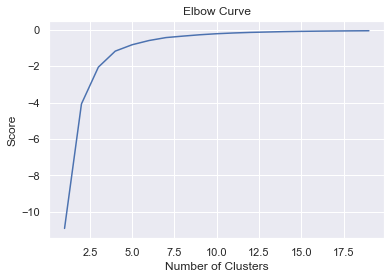

In [29]:
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [30]:
kmeans = KMeans(n_clusters = 20, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(10)

Venue ID   Latitude  Longitude  cluster_label
0  4bad596ff964a520f6483be3  40.611606 -74.155762             12
1  54c42298498e05bbd66a3e9d  40.606826 -74.162815             12
2  4d654338801854810ada5368  40.602300 -74.143267             12
3  5271a4dd11d29d353ab73ac4  40.600512 -74.162872             12
4  5aca35ef6f706a53e8564967  40.592496 -74.162623             12
5  4b71f6c5f964a52010672de3  40.612258 -74.132580             12
6  4c3b2b78def90f47e575fd2d  40.597782 -74.148204             12
7  5777f6eb498ecac8cfb24a82  40.608315 -74.162827             12
8  4cddf16869136dcbf3bcd2e6  40.621331 -74.031932              8
9  5e5bf16b6e4c95000781c85e  40.626259 -74.130139             12

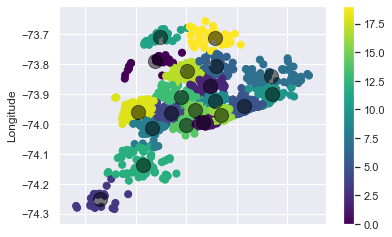

In [31]:
X.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [32]:
temp.head(5)

Unnamed: 0  ZIP Code          Venue Name                  Venue ID  Rating  \
0           0     10314            101 Cafe  4bad596ff964a520f6483be3       0   
1           1     10314         Tim Hortons  54c42298498e05bbd66a3e9d       0   
2           2     10314    Lifestyles Caffe  4d654338801854810ada5368       0   
3           3     10314  Chock Full Of Nuts  5271a4dd11d29d353ab73ac4       0   
4           4     10314           Starbucks  5aca35ef6f706a53e8564967       0   

    Latitude  Longitude  
0  40.611606 -74.155762  
1  40.606826 -74.162815  
2  40.602300 -74.143267  
3  40.600512 -74.162872  
4  40.592496 -74.162623

In [33]:
X.head(5)

Venue ID   Latitude  Longitude  cluster_label
0  4bad596ff964a520f6483be3  40.611606 -74.155762             12
1  54c42298498e05bbd66a3e9d  40.606826 -74.162815             12
2  4d654338801854810ada5368  40.602300 -74.143267             12
3  5271a4dd11d29d353ab73ac4  40.600512 -74.162872             12
4  5aca35ef6f706a53e8564967  40.592496 -74.162623             12

In [34]:
X = X[['Venue ID','cluster_label']]
X.head(5)

Venue ID  cluster_label
0  4bad596ff964a520f6483be3             12
1  54c42298498e05bbd66a3e9d             12
2  4d654338801854810ada5368             12
3  5271a4dd11d29d353ab73ac4             12
4  5aca35ef6f706a53e8564967             12

In [35]:
clustered_data = temp.merge(X, left_on='Venue ID', right_on='Venue ID')
clustered_data.head(5)

Unnamed: 0  ZIP Code          Venue Name                  Venue ID  Rating  \
0           0     10314            101 Cafe  4bad596ff964a520f6483be3       0   
1           1     10314         Tim Hortons  54c42298498e05bbd66a3e9d       0   
2           2     10314    Lifestyles Caffe  4d654338801854810ada5368       0   
3           3     10314  Chock Full Of Nuts  5271a4dd11d29d353ab73ac4       0   
4           4     10314           Starbucks  5aca35ef6f706a53e8564967       0   

    Latitude  Longitude  cluster_label  
0  40.611606 -74.155762             12  
1  40.606826 -74.162815             12  
2  40.602300 -74.143267             12  
3  40.600512 -74.162872             12  
4  40.592496 -74.162623             12

In [36]:
clustered_data.to_csv ('clustered_data.csv', index=None, header = True)

In [37]:
centers = kmeans.cluster_centers_
print(centers)

[[ 40.63887683 -73.79121909]
 [ 40.73291571 -73.99464598]
 [ 40.7482199  -73.87268314]
 [ 40.52857986 -74.25122343]
 [ 40.670322   -73.96436245]
 [ 40.81513637 -73.94105226]
 [ 40.75945494 -73.80858541]
 [ 40.86861477 -73.83896026]
 [ 40.63292964 -74.01399595]
 [ 40.75733493 -73.92272965]
 [ 40.86963451 -73.90150299]
 [ 40.64761242 -73.71133347]
 [ 40.613922   -74.1386479 ]
 [ 40.69051044 -73.91145568]
 [ 40.7002999  -74.00462932]
 [ 40.71673639 -73.95255136]
 [ 40.76914098 -73.97059765]
 [ 40.70182217 -73.82510883]
 [ 40.60350761 -73.95976037]
 [ 40.7569391  -73.71427364]]


In [46]:
count = pd.value_counts(clustered_data['cluster_label'])
cluster_count = pd.DataFrame({'cluster_label':count.index, 'Total':count.values})
cluster_count

cluster_label  Total
0               1    217
1              16    202
2               4    166
3               5    159
4              14    141
5               8    140
6               9    134
7              18    114
8              13    103
9              15     97
10              6     89
11              2     86
12             12     71
13             10     64
14             17     58
15              7     56
16             19     53
17              0     43
18             11     31
19              3     22

In [59]:
from folium.features import DivIcon
# create map
map_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
kclusters = 20
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(clustered_data['Latitude'], clustered_data['Longitude'] , clustered_data['cluster_label']):
    label = folium.Popup('Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

n=0

for lat, lng in centers:
    folium.CircleMarker(
        [lat, lng],
        radius = 75,
        color='blue',
        fill = True,
        fill_color='blue',
        fill_opacity=0.1
    ).add_to(map_clusters)

    text = "Cluster #{}".format(n)
    folium.map.Marker(
        [lat, lng-0.025],
        icon=DivIcon(
            icon_size=(150,36),
            icon_anchor=(0,0),
            html='<div style="font-size: 12pt"><b>%s</b></div>' % text,
            )
        ).add_to(map_clusters)
    n=n+1       
map_clusters.save("map_clusters.html")
map_clusters


## NYC Map with Map Clusters for Github Viewing

![NYC Map with Map Clusters](map_cluster.png)

## Results

In [39]:
print("The Neighborhood with the highest amount of coffee shops is:")
for index, row in coffee_shop_count[coffee_shop_count.Total==count.max()].iterrows():
    print("{} [{}]".format(row['Neighborhood'], row['Total']))

The Neighborhood with the highest amount of coffee shops is:
West Queens [132]


In [40]:
print("The Neighborhood with the fewest amount of coffee shops is:")
for index, row in coffee_shop_count[coffee_shop_count.Total==count.min()].iterrows():
    print("{} [{}]".format(row['Neighborhood'], row['Total']))

The Neighborhood with the fewest amount of coffee shops is:
East New York and New Lots [1]
Northeast Queens [1]
High Bridge and Morrisania [1]


In [49]:
print("The Cluster with the highest amount of coffee shops is:")
for index, row in cluster_count[cluster_count.Total==count.max()].iterrows():
    print("{} [{}]".format(row['cluster_label'], row['Total']))

The Cluster with the highest amount of coffee shops is:
1 [217]


In [52]:
print("The Cluster with the fewest amount of coffee shops is:")
for index, row in cluster_count[cluster_count.Total==count.min()].iterrows():
    print("{} [{}]".format(row['cluster_label'], row['Total']))

The Cluster with the fewest amount of coffee shops is:
3 [22]


From our statistical analysis:
- There is a high concentration of coffee shops in the neighborhoods: West Queens and Southeast Queens
- There is a lower concentration of coffee shops in the neighborhoods: High Bridge and Morrisania, East New York and New Lots, and Northeast Queens

From our machine learning analysis:
- There is a high concentration of coffee shops in cluster: 1
- There is a lower concentration of coffee shops in cluster: 3

## Discussion

The recommended areas to open up a coffee shop is **Lower Manhattan (Most Competition)** and **Southwest Queens (Least Competition)**. In my opinion, using prior knowledge of New York City, I would recommend openning a coffee shop in Lower Manhattan located in cluster 1 area since Southwest Queens area is where the JFK Airport is located in so there is not a lot of development in the area other than in the airport. An alternate location with most competition is **West Queens**, which can be represented by cluster #9 is the median point of the cluster but has the most coffee shops according to our statistical analysis of our returned query.

The result for this reocmmendation is very limited in terms of reliability and accuracy. For a more refined recommendation we would need to obtain more data such as population surveys on likelihood of patroning a coffee shop in X,Y,Z neighborhood and so on. Such data is out of the scope of this project and would require additional funding for further studies. Another thing to point out is that for Chloropleth Maps, the ZIP Codes plottted in polygons aren't 100% accurate since they are assembled with rectangles from Google Geocoding API so there are overlapping areas. I was unable to find an actual GeoJSON file with ZIP Codes mapped out. Another suggestion I would use to improve on this recommendation is incorporating crime statistics in the modelling in case the client would want preference over a safe neighborhood versus an unsafe neighborhood.

## Conclusion

From this Coursera Capstone project we combined machine learning (K-Means) and data visualization (Folium Maps) to make a recommendation for a location of business. I would like to thank IBM for creating this Cousera Course for introducing me to various Data Science topics using Python and available Python Libraries. 